## Plot results of training of a SVDTime Neural Network

This notebook displays the results of time fits for digit produced by the SVD digitizer.
The clusters are collected using the SVDFitclustersModule, and its output is imported and shown here. 

##### Required Python packages

The following python packages are used:
- math (basic python math functions)
- numpy (Vectors and matrices for numerics)
- pandas (Python analogue of Excel tables)
- matplotlib (Plotting library)
- seaborn (Advanced plotting)
- scipy (Scientific computing package)
- scikit-learn (machine learning)

If you get an error message complaining about a missing package, do

pip3 install *_package name_*

##### Other pre-requisites:

A sample of training data, plus binning and bounds information in pickle (*.pkl) files.

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
from scipy import stats as stats
from scipy.optimize import minimize_scalar
from svd.SVDSimBase import *

Welcome to JupyROOT 6.08/06


### Retrieve dumped digit fits

In [2]:
cluster_fit_filename = '/media/sf_MateShare/kvasnicka/tb2017/output-5/dumped_tb_clusters.txt'

clusters = pd.read_csv(cluster_fit_filename, index_col = False, delim_whitespace = True)

pkl_name = 'SVDTime_TrainingBins_1000000.pkl'
bins = pd.read_pickle(pkl_name)

timearray = bins['midpoint']
timebins = np.unique(bins[['lower','upper']])

In [3]:
clusters.head()

,EventNo,Layer,Ladder,Sensor,Side,Position,Bg,Time_event,Time_cluster,Charge_cluster,Size_cluster,Chi2_cluster
0,14,3,1,2,u,-0.482356,s,-11.79,-25.492321,24793.705078,2,1.412855
1,14,3,1,2,u,-0.043126,s,-11.79,-24.204235,15250.776367,1,1.197790
2,14,3,1,2,u,0.067218,s,-11.79,-24.204235,13168.168945,1,1.788003
3,14,3,1,2,u,0.280018,s,-11.79,-25.492321,24488.626953,2,1.464763
4,14,3,1,2,v,1.312607,s,-11.79,-45.952068,24919.156250,2,3.390194


We add a random column for sampling. We set the value to negative for rows we want to exclude from sampling. First thhing we exclude bad strips from consideration.

Index(['EventNo', 'Layer', 'Ladder', 'Sensor', 'Side', 'Position', 'Bg',
       'Time_event', 'Time_cluster', 'Charge_cluster', 'Size_cluster',
       'Chi2_cluster', 'Test'],
      dtype='object')

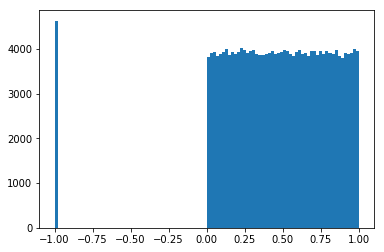

In [4]:
clusters['Test'] = np.random.uniform(0.0,1.0,len(clusters))
clusters['Test'] = clusters.apply(lambda row: row.Test if row.Time_cluster != 0.0 else -1, axis = 1)
plt.hist(clusters.Test, bins = 100);
clusters.columns

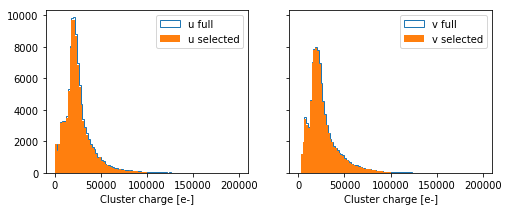

In [5]:
amplitude_low = 0
amplitude_high = 100000
clusters.Test = clusters.apply(lambda row: row.Test if (row.Charge_cluster > amplitude_low and row.Charge_cluster < amplitude_high) else -1.0, axis = 1)
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize=(8,3))
for side, i in zip(['u','v'], range(2)):
    (freqs, fullbins, patches) = ax[i].hist(clusters.Charge_cluster[np.logical_and(clusters.Side==side, clusters.Charge_cluster < 200000)], histtype = 'step', bins = 100, label = side + ' full');
    ax[i].hist(clusters.Charge_cluster[np.logical_and(clusters.Side==side, clusters.Test>0.0)], histtype = 'stepfilled', bins = fullbins, label = side + ' selected');
    ax[i].legend()
    ax[i].set_xlabel('Cluster charge [e-]')
plt.savefig('Cluster_charge_selection.png')

Now we also exclude data with extremely bad fits.

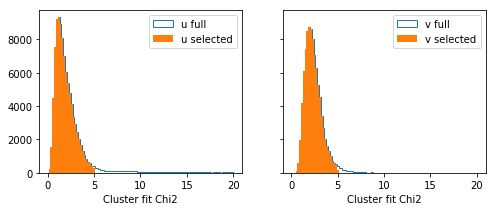

In [6]:
max_chi2 = 5
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize=(8,3))
for side, i in zip(['u','v'], range(2)):
    (freqs, fullbins, patches) = ax[i].hist(clusters.Chi2_cluster[clusters.Chi2_cluster < 20][np.logical_and(clusters.Side==side, clusters.Test > 0.0)], histtype = 'step', bins = 100, label = side + ' full');
    clusters.Test = clusters.apply(lambda row: row.Test if row.Side != side or row.Chi2_cluster < max_chi2 else -1.0, axis = 1)
    ax[i].hist(clusters.Chi2_cluster[np.logical_and(clusters.Side==side, clusters.Test>0.0)], histtype = 'stepfilled', bins = fullbins, label = side + ' selected');
    ax[i].legend()
    ax[i].set_xlabel('Cluster fit Chi2')
plt.savefig('Cluster_chi2_selection.png')

### Try to optimize shifts

Find time shifts that reconstruct a credible DAQ scenario.

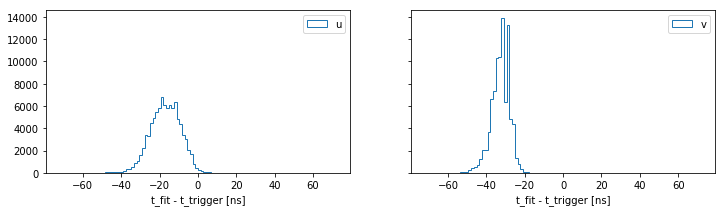

In [7]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize=(12,3))
for side, i in zip(['u','v'], range(2)):
    ax[i].hist(
        clusters.Time_cluster[np.logical_and(clusters.Test > 0.0, clusters.Side==side)] 
        - clusters.Time_event[np.logical_and(clusters.Test > 0.0, clusters.Side==side)], 
        bins = 100, histtype = 'step', cumulative = False, label = side);
    ax[i].legend()
    ax[i].set_xlabel('t_fit - t_trigger [ns]')
plt.savefig('FitMinusTrigger.png')

###  Match distribution of times

Another idea is to start matching time distributions. 
Next, match the distribution to the interval -31.44 to 0
Next, estimate event time.
And last, adjust widths by adjusting time distribution.

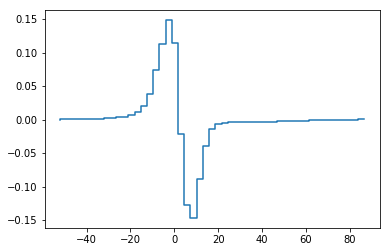

/home/kvasnicka/work/belle2_new/externals/v01-05-01/Linux_x86_64/opt/root/lib/ROOT.py:303: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return _orig_ihook( name, *args, **kwds )


In [8]:
import statsmodels.api as sm # recommended import according to the docs

u_times = 20+clusters.Time_cluster[np.logical_and(clusters.Test > 0.0, clusters.Side=='u')] - clusters.Time_event[np.logical_and(clusters.Test > 0.0, clusters.Side=='u')]
v_times = 20+16+clusters.Time_cluster[np.logical_and(clusters.Test > 0.0, clusters.Side=='v')] - clusters.Time_event[np.logical_and(clusters.Test > 0.0, clusters.Side=='v')]

ecdf_u = sm.distributions.ECDF(u_times)
ecdf_v = sm.distributions.ECDF(v_times)

t = np.linspace(min(u_times), max(u_times))
u = ecdf_u(t)
v = ecdf_v(t)
plt.step(t, u-v)

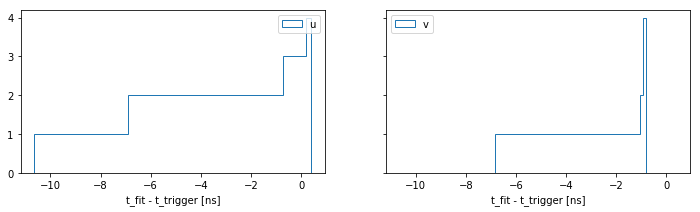

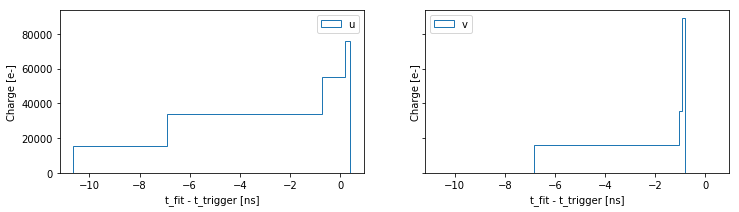

In [15]:
t_adjustment = { 'u': 20, 'v': 36 }
event_data = clusters[clusters.EventNo == 3690]
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize=(12,3))
for side, i in zip(['u','v'], range(2)):
    ax[i].hist(
        t_adjustment[side] 
        + event_data.Time_cluster[np.logical_and(event_data.Test > 0.0, event_data.Side==side)] 
        - event_data.Time_event[np.logical_and(event_data.Test > 0.0, event_data.Side==side)],
        bins = 50, histtype = 'step', cumulative = True, label = side
    );
    ax[i].legend()
    ax[i].set_xlabel('t_fit - t_trigger [ns]')
plt.savefig('EventFitMinusTrigger.png')
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize=(12,3))
for side, i in zip(['u','v'], range(2)):
    ax[i].hist(
        t_adjustment[side] 
        + event_data.Time_cluster[np.logical_and(event_data.Test > 0.0, event_data.Side==side)] 
        - event_data.Time_event[np.logical_and(event_data.Test > 0.0, event_data.Side==side)], 
        weights = event_data.Charge_cluster[np.logical_and(event_data.Test > 0.0, event_data.Side==side)], 
        bins = 50, histtype = 'step', cumulative = True, label = side
    );
    ax[i].legend()
    ax[i].set_xlabel('t_fit - t_trigger [ns]')
    ax[i].set_ylabel('Charge [e-]')
plt.savefig('EventChargeFitMinusTrigger.png')

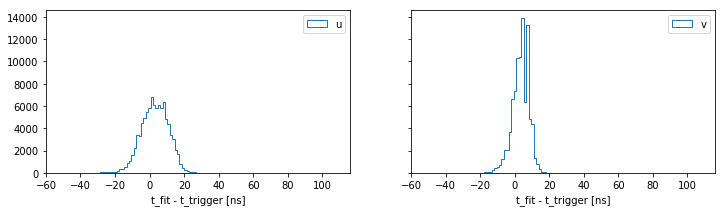

In [10]:
t_adjustment = { 'u': 20, 'v': 36 }
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize=(12,3))
for side, i in zip(['u','v'], range(2)):
    ax[i].hist(
        t_adjustment[side]
        + clusters.Time_cluster[np.logical_and(clusters.Test > 0.0, clusters.Side==side)] 
        - clusters.Time_event[np.logical_and(clusters.Test > 0.0, clusters.Side==side)], 
        bins = 100, histtype = 'step', cumulative = False, label = side);
    ax[i].legend()
    ax[i].set_xlabel('t_fit - t_trigger [ns]')
plt.savefig('FitMinusTriggerAdjusted.png')